In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (2).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (285).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (166)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (300).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (390).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (357).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (261)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUS

# Prerequisites

In [52]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import glob
import  random
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
import warnings
warnings.filterwarnings('ignore')
import pathlib
from pathlib import Path

# Dataset Loading

In [70]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ------------------- LOAD DATA -------------------

img_size = 256
batch_size = 16

def load_images_and_masks(folder_path):
    files = sorted(os.listdir(folder_path))
    images, masks = [], []

    for file in files:
        if "mask" in file.lower():
            continue

        img_path = os.path.join(folder_path, file)
        mask_path = os.path.join(folder_path, file.replace(".png", "_mask.png"))

        if not os.path.exists(mask_path):
            continue

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (img_size, img_size)) / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size))
        mask = np.expand_dims(mask, axis=-1) / 255.0

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Detect actual folder names (case insensitive)
data_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
folders = os.listdir(data_path)
benign_folder = [f for f in folders if f.lower() == "benign"][0]  
malignant_folder = [f for f in folders if f.lower() == "malignant"][0]  

benign_images, benign_masks = load_images_and_masks(os.path.join(data_path, benign_folder))
malignant_images, malignant_masks = load_images_and_masks(os.path.join(data_path, malignant_folder))

X = np.concatenate((benign_images, malignant_images), axis=0)
Y = np.concatenate((benign_masks, malignant_masks), axis=0)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [72]:

# ------------------- DATA AUGMENTATION -------------------

datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# ------------------- BUILD SEGMENTATION MODEL -------------------

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def upsample_block(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_model():
    vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_size, img_size, 3)))
    for layer in vgg16.layers:
        layer.trainable = False

    s1, s2, s3, s4 = vgg16.get_layer("block1_conv2").output, vgg16.get_layer("block2_conv2").output, vgg16.get_layer("block3_conv3").output, vgg16.get_layer("block4_conv3").output
    bridge = vgg16.get_layer("block5_conv3").output

    d1 = upsample_block(bridge, s4, 512)
    d2 = upsample_block(d1, s3, 256)
    d3 = upsample_block(d2, s2, 128)
    d4 = upsample_block(d3, s1, 64)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(d4)
    model = Model(vgg16.input, outputs)
    return model

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])



In [73]:
# ------------------- TRAIN MODEL -------------------

train_generator = datagen.flow(X_train, Y_train, batch_size=batch_size)
val_generator = datagen.flow(X_val, Y_val, batch_size=batch_size)

history = model.fit(train_generator, validation_data=val_generator, epochs=50)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 70s 949ms/step - accuracy: 0.7912 - loss: 0.5212 - val_accuracy: 0.6585 - val_loss: 0.6147
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 327ms/step - accuracy: 0.8973 - loss: 0.3451 - val_accuracy: 0.7038 - val_loss: 0.6322
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step - accuracy: 0.9043 - loss: 0.2820 - val_accuracy: 0.6191 - val_loss: 0.6815
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step - accuracy: 0.9160 - loss: 0.2426 - val_accuracy: 0.8979 - val_loss: 0.4151
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 326ms/step - accuracy: 0.9129 - loss: 0.2376 - val_accuracy: 0.9039 - val_loss: 0.3244
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 331ms/step - accuracy: 0.9162 - loss: 0.2269 - val_accuracy: 0.8923 - val_loss: 0.3206
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 325ms/step - accuracy: 0.9189 - loss: 0.2213 - val_accuracy: 0.9003 - val_loss: 0.2753
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 330ms/step - accuracy: 0.9162 - loss: 0.2244 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


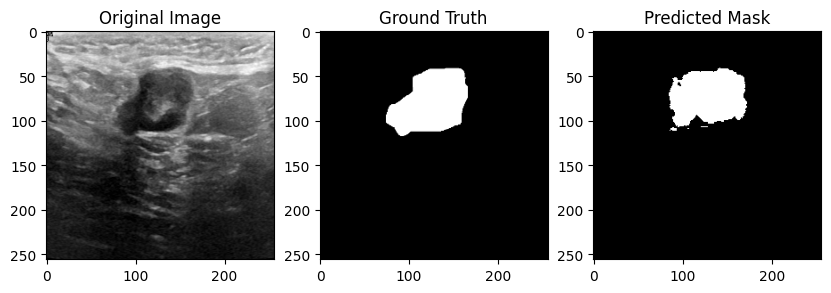

In [74]:

# ------------------- VISUALIZE RESULTS -------------------

def predict_sample(sample_index):
    sample_img = X_val[sample_index]
    sample_mask = Y_val[sample_index]
    pred_mask = model.predict(np.expand_dims(sample_img, axis=0))[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(sample_img)
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(sample_mask[:, :, 0], cmap="gray")
    plt.title("Ground Truth")
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[:, :, 0], cmap="gray")
    plt.title("Predicted Mask")
    plt.show()

predict_sample(0)